## Imports

In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import torch as torch

# Question 1

## Numpy version of code

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [5]:
# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
print(U.shape)
print(S.shape)
print(V.shape)
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 966)
(966,)
(966, 1850)
(966, 150)
(322, 150)


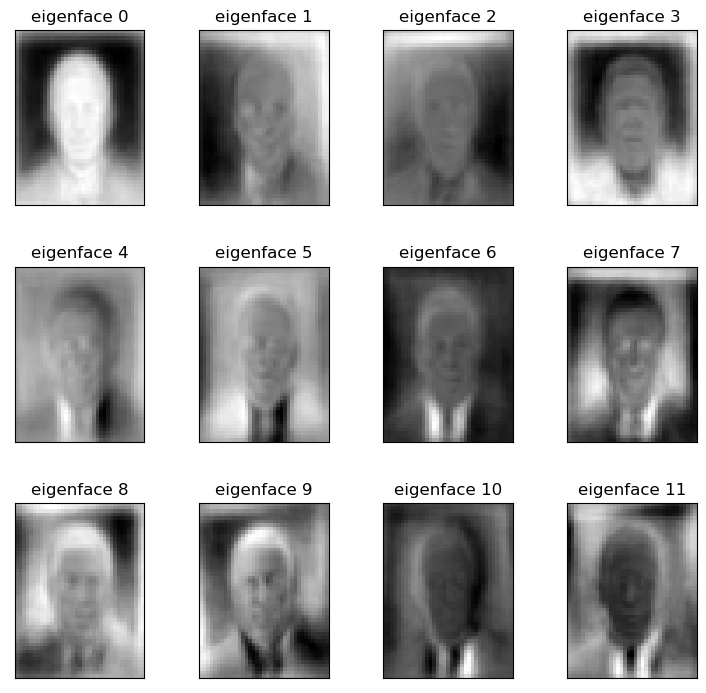

In [6]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


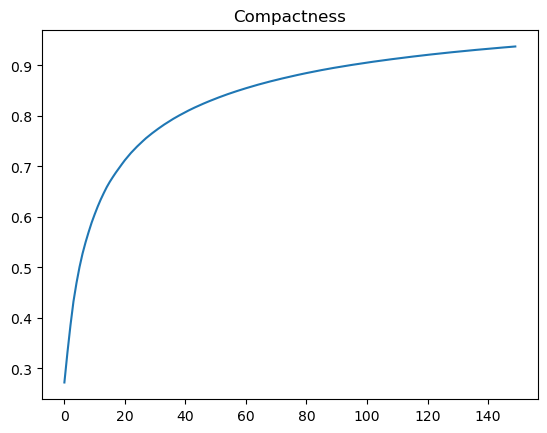

In [7]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [8]:
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

Total Testing 322
Predictions [3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 1 1 3 1 3 3 1 1 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 1 3 3 3 3 4 3 3 6 3 3 3
 3 1 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 1 3 3 3 3 3 3 3
 1 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 6 6 3 3 3 3 3 1 6 6 3 3 1 3 3 1 3
 3 1 3 3 3 3 3 3 3 3 1 3 6 3 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 1 3
 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 1 1 6 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 6
 3 3 3 3 3 3 3 1 1 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 1
 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3]
Which Correct: [ True  True False  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True False False False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True False  True  True  True  True False  True  True False  True
 False  T

In [9]:
print(classification_report(y_test, predictions, target_names=target_names, zero_division=0.0))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.08      0.14        13
     Colin Powell       0.75      0.45      0.56        60
  Donald Rumsfeld       1.00      0.04      0.07        27
    George W Bush       0.53      0.99      0.69       146
Gerhard Schroeder       1.00      0.04      0.08        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.73      0.22      0.34        36

         accuracy                           0.57       322
        macro avg       0.72      0.26      0.27       322
     weighted avg       0.66      0.57      0.47       322



## pytorch implementation

In [10]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
X = torch.from_numpy(X)
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
y = torch.from_numpy(y)
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [11]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print(X_train.shape)
print(X_test.shape)

torch.Size([966, 1850])
torch.Size([322, 1850])


In [12]:
# Center data
mean = torch.mean(X_train)
X_train -= mean
X_test -= mean

U, S, V = torch.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
# print(U.shape, S.shape, V.shape)
# print(components.T.shape)
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = torch.mm(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.mm(X_test, components.T)
print(X_test_transformed.shape)

torch.Size([966, 150])
torch.Size([322, 150])


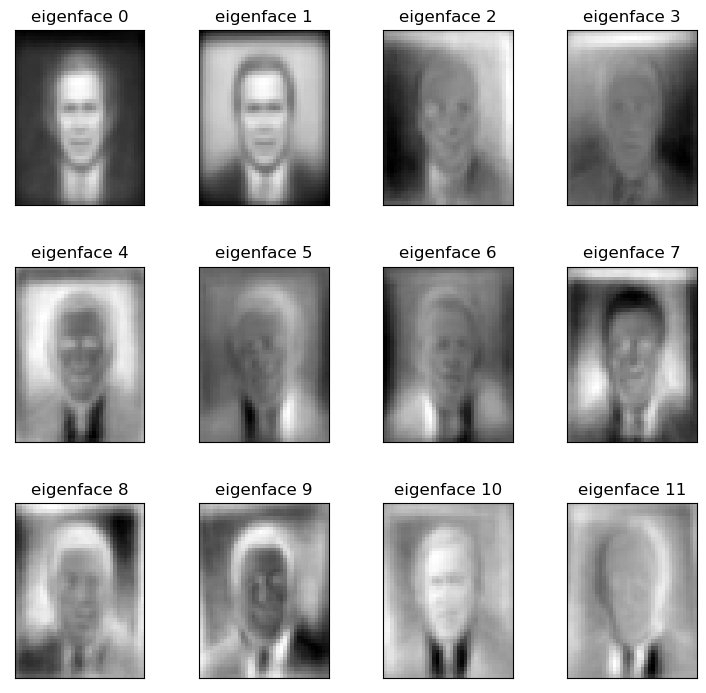

In [13]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

torch.Size([966])


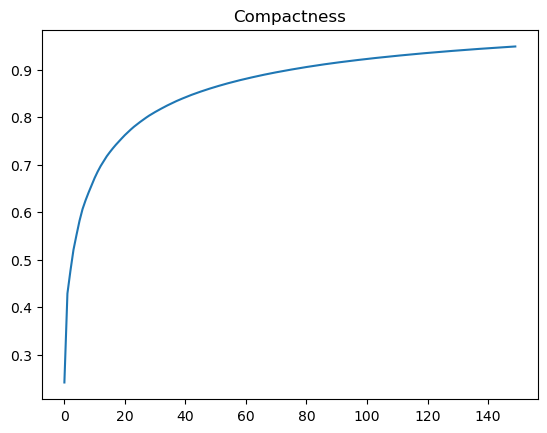

In [14]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, 0)
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [15]:
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = torch.from_numpy(estimator.predict(X_test_transformed))
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",torch.sum(correct))
print("Accuracy:",torch.sum(correct)/total_test)

Total Testing 322
Predictions tensor([3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 4, 3,
        3, 3, 3, 3, 3, 3, 6, 1, 3, 3, 3, 3, 1, 3, 1, 6, 1, 3, 3, 4, 1, 3, 1, 3,
        3, 3, 3, 3, 1, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 1, 6, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3,
        3, 1, 3, 3, 6, 1, 1, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 3, 3, 1, 3, 3, 6, 1,
        3, 3, 1, 3, 6, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 1, 1, 3, 3, 3, 1,
        3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3,
        3,

In [16]:
print(classification_report(y_test, predictions, target_names=target_names, zero_division=0.0))

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.08      0.13        13
     Colin Powell       0.64      0.42      0.51        60
  Donald Rumsfeld       0.50      0.07      0.13        27
    George W Bush       0.54      0.96      0.69       146
Gerhard Schroeder       1.00      0.12      0.21        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.69      0.25      0.37        36

         accuracy                           0.56       322
        macro avg       0.55      0.27      0.29       322
     weighted avg       0.58      0.56      0.48       322



# Question 2

## CNN Setup

In [51]:
import torch.nn as nn

class DenseOnlyCNN(nn.Module):
    def __init__(self):
        super(DenseOnlyCNN, self).__init__()
        self.fc1 = nn.Linear(250*250*3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 7)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [52]:
from torchvision import datasets
import torchvision.transforms as tf
train_set = datasets.LFWPeople('./LFW_people_data', "train", download=True, transform=tf.ToTensor())
test_set = datasets.LFWPeople('./LFW_people_data', "test", download=True, transform=tf.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 250, 250]) torch.Size([64])
0


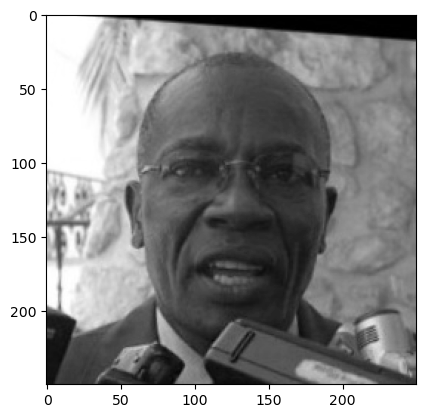

tensor(2134)
tensor([[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9961, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9922, 0.9961, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0745, 0.0745, 0.0627,  ..., 0.2314, 0.2157, 0.2275],
        [0.0824, 0.0667, 0.0627,  ..., 0.2157, 0.2118, 0.2118],
        [0.0824, 0.0706, 0.0706,  ..., 0.2000, 0.2039, 0.2039]])


In [53]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

# Using the dataloader

loader = enumerate(train_dl)
batch, (x,y) = next(loader)
print(x.shape, y.shape)
print(batch)
# print(48 * 64)

import matplotlib.pyplot as plt
plt.imshow(x[0][0], cmap='gray')
plt.show()
print(y[0])
print(x[0][0])


In [54]:
LR = 0.1
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
model = DenseOnlyCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
DEVICE = 'mps'

In [55]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device=DEVICE)
        y = y.to(device=DEVICE)
        #compute prediction and loss
        pred = model.forward(X)
        loss = loss_fn(pred, y)

        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%50 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device=DEVICE)
            y = y.to(device=DEVICE)

            pred = model.forward(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [56]:
model = model.to(device=DEVICE)

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n ++++++++++++++++++++++++++++++++++++++++++++++++")
    train_loop(train_dl, model, loss_fn, optimizer)
    test_loop(test_dl, model, loss_fn)
print("Done!")

Epoch 1
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 0.000000  [    0/ 9525]
loss: 0.000000  [ 3200/ 9525]
loss: 0.000000  [ 6400/ 9525]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001167 

Epoch 2
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 0.000000  [    0/ 9525]
loss: 0.000000  [ 3200/ 9525]
loss: 0.033835  [ 6400/ 9525]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001167 

Epoch 3
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 0.000000  [    0/ 9525]
loss: 0.000000  [ 3200/ 9525]
loss: 0.000000  [ 6400/ 9525]



KeyboardInterrupt

